1. Draw 1,000 observations from a bivariate Normal distribution with unit
standard deviations and a correlation coefficient ρ $\in \{-1, -0.5, 0, 0.5, 1\}$

In [5]:
import numpy as np
import pandas as pd

np.random.seed(42)

n_samples=1000
rhos=[-1, -0.5, 0, 0.5, 1]
rho_X=[]

mu=np.array([0, 0])
for rho in rhos:
    cov=np.array([[1, rho], [rho, 1]])
    X=np.random.multivariate_normal(mu, cov, n_samples)
    rho_X.append(X)
    

1-a. Discretize the samples, following the method described in Section 3.9.

In [21]:
def get_optimal_bin_width(N:int) -> int:
    '''
    Calculate the optimal bin width for discretized data using Hacine-Gharbi's method.
    '''
    optimal_tau=np.cbrt(8+324*N+12*np.sqrt(36*N+729*N**2))
    optimal_bin_width=np.round(optimal_tau/6+2/(3*optimal_tau)+1/3)
    return optimal_bin_width

def get_optimal_bin_width_2d(N:int, corr:float):
    temp=1+24*N/((1-corr**2)+1e-4)  # Adding a small value to avoid division by zero
    temp=1+np.sqrt(temp)
    return np.round(np.sqrt(temp)*(1/np.sqrt(2)))

def get_discretized_data(X:np.ndarray, bin_method:str='hacine-gharbi') -> pd.DataFrame:

    if bin_method not in ['auto', 'hacine-gharbi']:
        raise ValueError("bin_method must be either 'auto' or 'optimal'")
    N = len(X)
    if bin_method == 'hacine-gharbi':
        if X.ndim == 1:
            optimal_bin_width=int(get_optimal_bin_width(N))
        elif X.ndim == 2:
            corr= np.corrcoef(X, rowvar=False)[0, 1]
            optimal_bin_width=int(get_optimal_bin_width_2d(N, corr))
    elif bin_method == 'auto':
        if X.ndim == 1:
            optimal_bin_width='auto'
        elif X.ndim == 2:
            optimal_bin_width=(int(np.sqrt(N)), int(np.sqrt(N)))

    if X.ndim == 1:
        counts, bin_edges = np.histogram(X, bins=optimal_bin_width, density=False)
        delta = bin_edges[1] - bin_edges[0]
        probs = counts / np.sum(counts)
        return probs, delta, counts, bin_edges
    elif X.ndim == 2:
        counts, xedges, yedges = np.histogram2d(X[:, 0], X[:, 1], bins=optimal_bin_width, density=False)
        delta = (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
        probs = counts / np.sum(counts)
        return probs.flatten(), delta, counts, (xedges, yedges)

1-b. Compute $H[X],\ H[Y],\ H[X, Y],\ H[X|Y],\ I[X, Y],\ VI[X, Y]\ and\ \bar{VI}[X, Y]$

In [22]:
def get_entropy(X: np.ndarray, bin_method:str='auto') -> float:
    '''
    Calculate the entropy of discretized data.
    '''
    probs, delta_x, counts, _ = get_discretized_data(X, bin_method=bin_method)
    probs = probs[probs > 0]  # Filter out zero probabilities
    entropy = -np.sum(probs * np.log(probs)) + np.log(delta_x)  # Add log(delta_x) for normalization
    return entropy

def get_joint_entropy(X: np.ndarray, Y: np.ndarray, bin_method:str='auto') -> float:
    '''
    Calculate the joint entropy of two discretized datasets.
    '''
    joint_data = np.vstack((X, Y)).T
    joint_probs, delta_xy, _, _ = get_discretized_data(joint_data, bin_method=bin_method)
    joint_probs = joint_probs[joint_probs > 0]  # Filter out zero probabilities
    joint_entropy = -np.sum(joint_probs * np.log(joint_probs)) + np.log(delta_xy)  # Add log(delta_xy) for normalization
    return joint_entropy


def get_conditional_entropy(X: np.ndarray, Y: np.ndarray, bin_method:str='auto') -> float:
    '''
    Calculate the conditional entropy H(X|Y).
    '''
    joint_entropy = get_joint_entropy(X, Y, bin_method=bin_method)
    entropy_Y = get_entropy(Y, bin_method=bin_method)
    conditional_entropy = joint_entropy - entropy_Y
    return conditional_entropy

def get_mutual_information(X: np.ndarray, Y: np.ndarray, bin_method:str='auto') -> float:
    '''
    Calculate the mutual information I(X;Y).
    '''
    entropy_X = get_entropy(X, bin_method=bin_method)
    entropy_Y = get_entropy(Y, bin_method=bin_method)
    joint_entropy = get_joint_entropy(X, Y, bin_method=bin_method)
    mutual_information = entropy_X + entropy_Y - joint_entropy
    return mutual_information

def get_variation_of_information(X: np.ndarray, Y: np.ndarray, normalized=False, bin_method:str='auto') -> float:
    '''
    Calculate the variation of information VI(X;Y).
    '''
    joint_entropy = get_joint_entropy(X, Y, bin_method=bin_method)
    entropy_X=get_entropy(X, bin_method=bin_method)
    entropy_Y=get_entropy(Y, bin_method=bin_method)
    conditional_entropy_X_given_Y = get_conditional_entropy(X, Y, bin_method=bin_method)
    conditional_entropy_Y_given_X = get_conditional_entropy(Y, X, bin_method=bin_method)

    if normalized:
        vi = max(conditional_entropy_X_given_Y, conditional_entropy_Y_given_X) / max(entropy_X, entropy_Y)
    else:
        vi = conditional_entropy_X_given_Y + conditional_entropy_Y_given_X
    return vi

H_X_list = []
H_Y_list = []
H_XY_list = []
H_X_given_Y_list = []
I_XY_list = []
VI_XY_list = []
VI_bar_XY_list = []
for i, rho in enumerate(rhos):
    X = rho_X[i][:, 0]
    Y = rho_X[i][:, 1]
    
    H_X = get_entropy(X)
    H_Y = get_entropy(Y)
    H_XY = get_joint_entropy(X, Y)
    H_X_given_Y = get_conditional_entropy(X, Y)
    I_XY = get_mutual_information(X, Y)
    VI_XY = get_variation_of_information(X, Y)
    VI_bar_XY = get_variation_of_information(X, Y, normalized=True)

    H_X_list.append(H_X)
    H_Y_list.append(H_Y)
    H_XY_list.append(H_XY)
    H_X_given_Y_list.append(H_X_given_Y)
    I_XY_list.append(I_XY)
    VI_XY_list.append(VI_XY)
    VI_bar_XY_list.append(VI_bar_XY)

1-c. Are $H[X]$ and $H[Y]$ is affected by $\rho$ ?

변하긴 하는데 y축 scale이 매우작아서 거의 변하지 않는다.

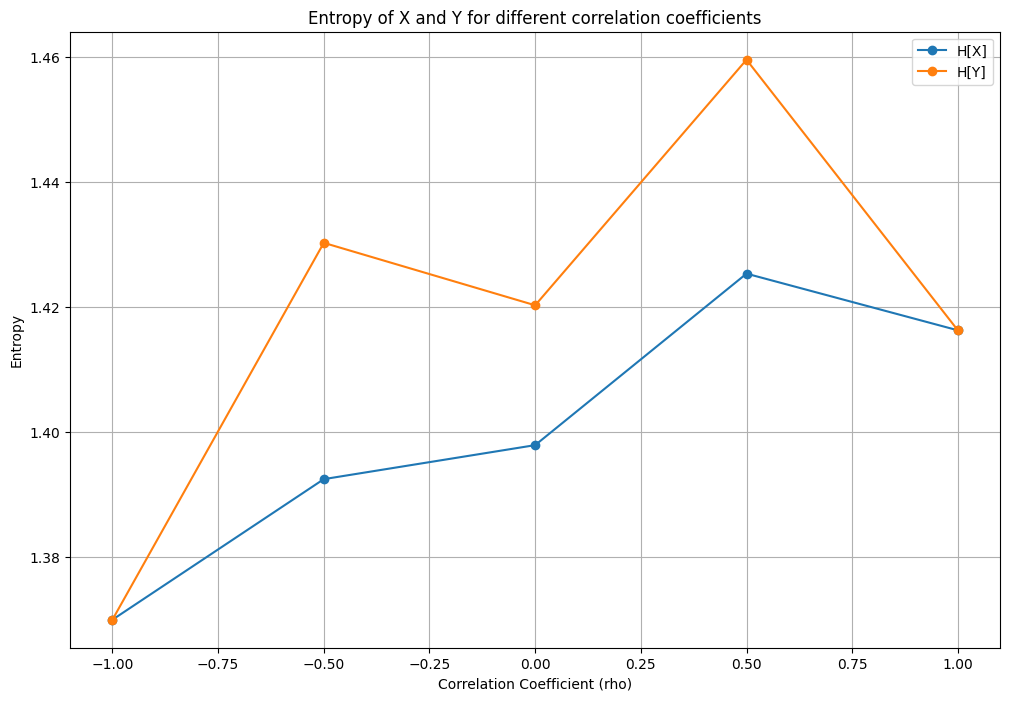

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(rhos, H_X_list, marker='o', label='H[X]')
plt.plot(rhos, H_Y_list, marker='o', label='H[Y]')
plt.legend()
plt.title('Entropy of X and Y for different correlation coefficients')
plt.xlabel('Correlation Coefficient (rho)')
plt.ylabel('Entropy')
plt.grid()
plt.show()

1-d. Are $\ H[X, Y],\ H[X|Y],\ I[X, Y],\ VI[X, Y]\ and\ \bar{VI}[X, Y]$ is affected by $\rho$?

$\bar{VI}$를 제외한 변수들은 $\rho$가 0에 가까워질 수록 상승하고 $\bar{VI}$ 의 경우 비율이기 때문에 오히려 $\rho$가 극단적일때 값이 크다

Text(0.5, 0, 'Correlation Coefficient (rho)')

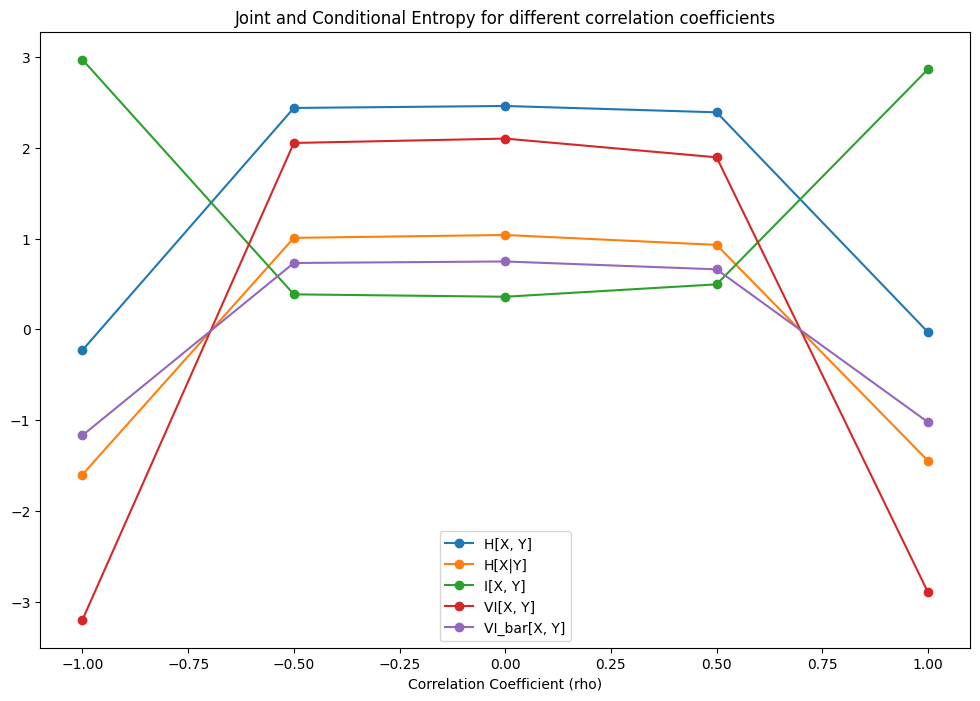

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(rhos, H_XY_list, marker='o', label='H[X, Y]')
plt.plot(rhos, H_X_given_Y_list, marker='o', label='H[X|Y]')
plt.plot(rhos, I_XY_list, marker='o', label='I[X, Y]')
plt.plot(rhos, VI_XY_list, marker='o', label='VI[X, Y]')
plt.plot(rhos, VI_bar_XY_list, marker='o', label='VI_bar[X, Y]')
plt.legend()
plt.title('Joint and Conditional Entropy for different correlation coefficients')
plt.xlabel('Correlation Coefficient (rho)')

2. Repeat Exercise 1, this time for 1 million observations. What variables are
impacted by the different sample size?

1의 exercise의 경향이 더 두드러진다.

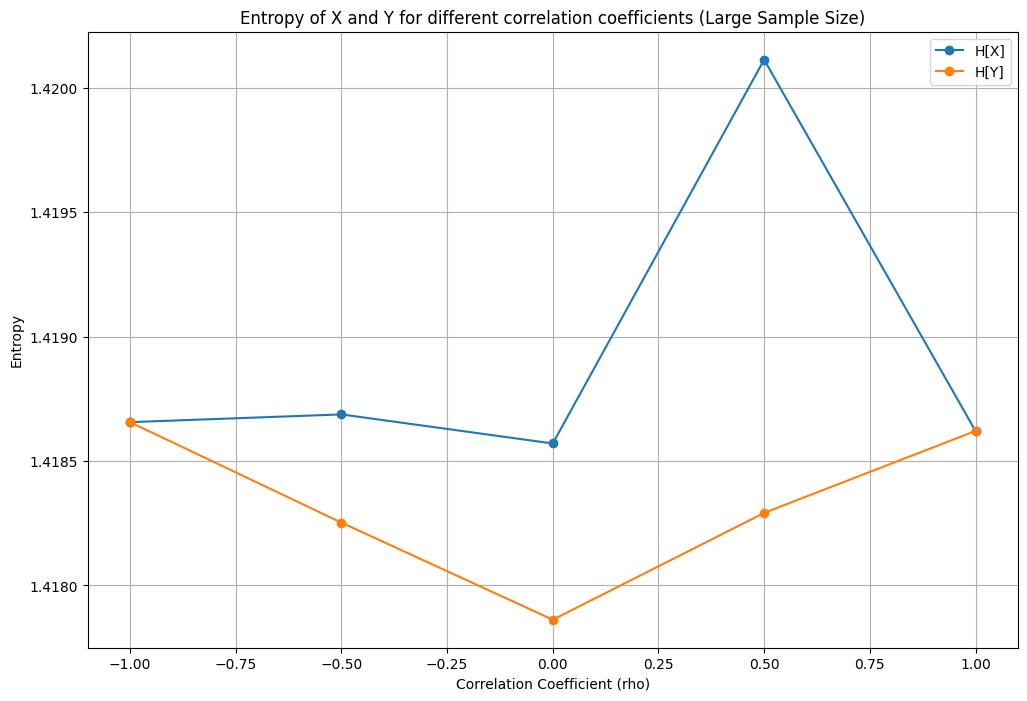

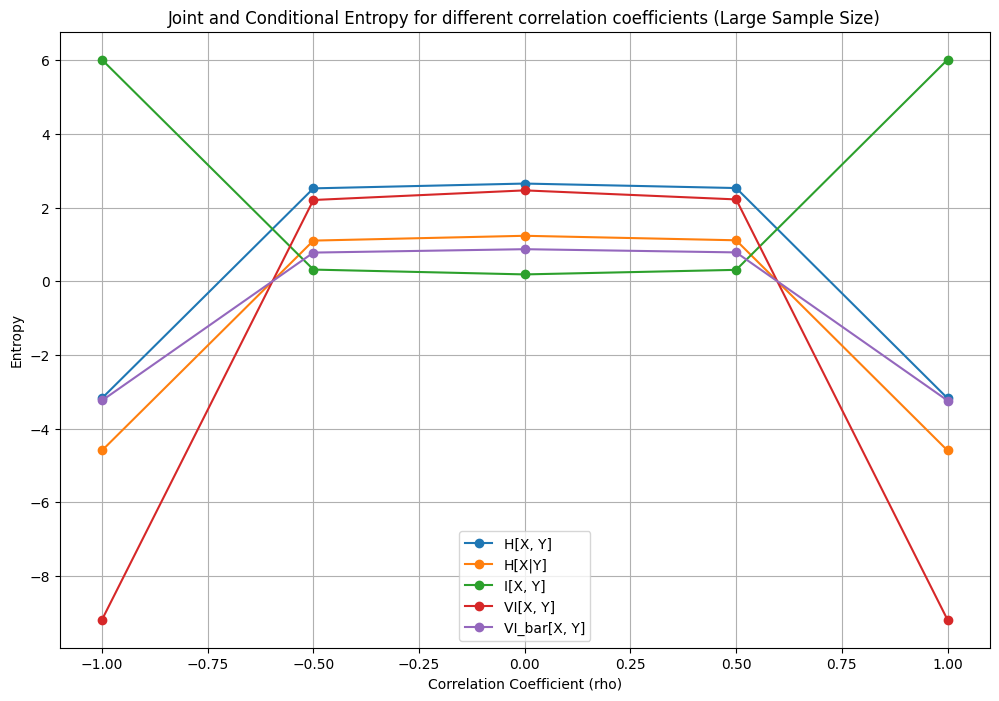

In [19]:
n_samples=1000000

rho_X_M=[]
for rho in rhos:
    cov=np.array([[1, rho], [rho, 1]])
    X_M=np.random.multivariate_normal(mu, cov, n_samples)
    rho_X_M.append(X_M)

H_X_M_list = []
H_Y_M_list = []
H_XY_M_list = []
H_X_given_Y_M_list = []
I_XY_M_list = []
VI_XY_M_list = []
VI_bar_XY_M_list = []
for i, rho in enumerate(rhos):  
    X_M = rho_X_M[i][:, 0]
    Y_M = rho_X_M[i][:, 1]
    
    H_X_M = get_entropy(X_M)
    H_Y_M = get_entropy(Y_M)
    H_XY_M = get_joint_entropy(X_M, Y_M)
    H_X_given_Y_M = get_conditional_entropy(X_M, Y_M)
    I_XY_M = get_mutual_information(X_M, Y_M)
    VI_XY_M = get_variation_of_information(X_M, Y_M)
    VI_bar_XY_M = get_variation_of_information(X_M, Y_M, normalized=True)

    H_X_M_list.append(H_X_M)
    H_Y_M_list.append(H_Y_M)
    H_XY_M_list.append(H_XY_M)
    H_X_given_Y_M_list.append(H_X_given_Y_M)
    I_XY_M_list.append(I_XY_M)
    VI_XY_M_list.append(VI_XY_M)
    VI_bar_XY_M_list.append(VI_bar_XY_M)


plt.figure(figsize=(12, 8))
plt.plot(rhos, H_X_M_list, marker='o', label='H[X]')
plt.plot(rhos, H_Y_M_list, marker='o', label='H[Y]')
plt.legend()
plt.title('Entropy of X and Y for different correlation coefficients (Large Sample Size)')
plt.xlabel('Correlation Coefficient (rho)')
plt.ylabel('Entropy')
plt.grid()
plt.show()  

plt.figure(figsize=(12, 8))
plt.plot(rhos, H_XY_M_list, marker='o', label='H[X, Y]')
plt.plot(rhos, H_X_given_Y_M_list, marker='o', label='H[X|Y]')
plt.plot(rhos, I_XY_M_list, marker='o', label='I[X, Y]')
plt.plot(rhos, VI_XY_M_list, marker='o', label='VI[X, Y]')
plt.plot(rhos, VI_bar_XY_M_list, marker='o', label='VI_bar[X, Y]')
plt.legend()
plt.title('Joint and Conditional Entropy for different correlation coefficients (Large Sample Size)')
plt.xlabel('Correlation Coefficient (rho)')
plt.ylabel('Entropy')
plt.grid()
plt.show()

3. Repeat Exercise 2, where this time you use the discretization step BX from
Exercise 1. How does this impact the results?

Joint과 conditional이 극단적인 값이 나오는 현상이 좀 더 줄어들었다.

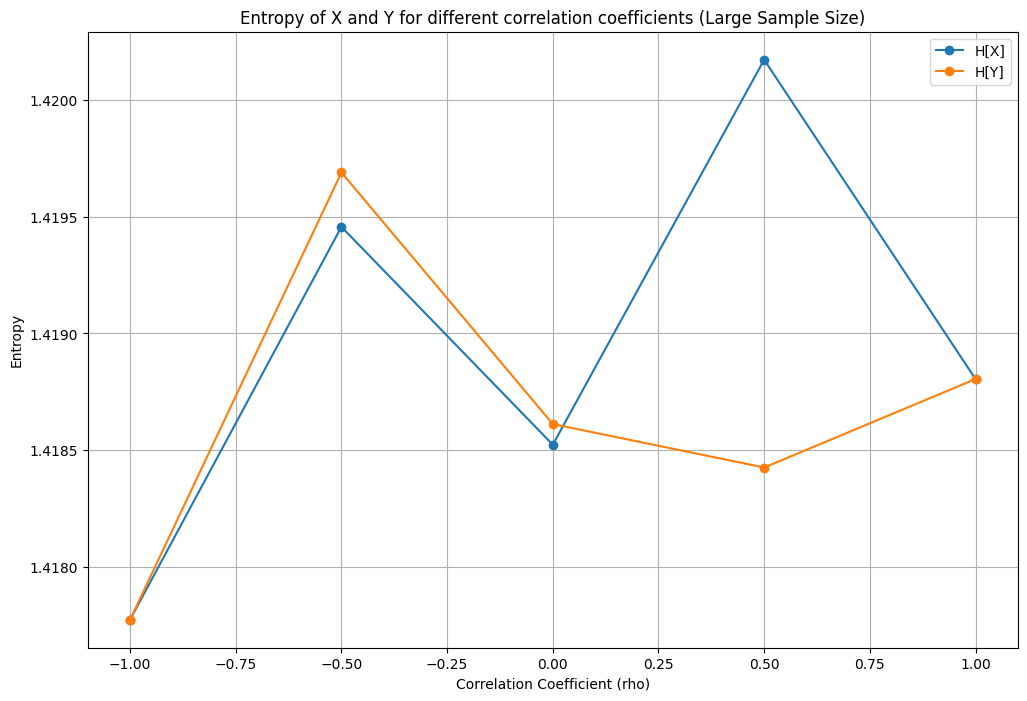

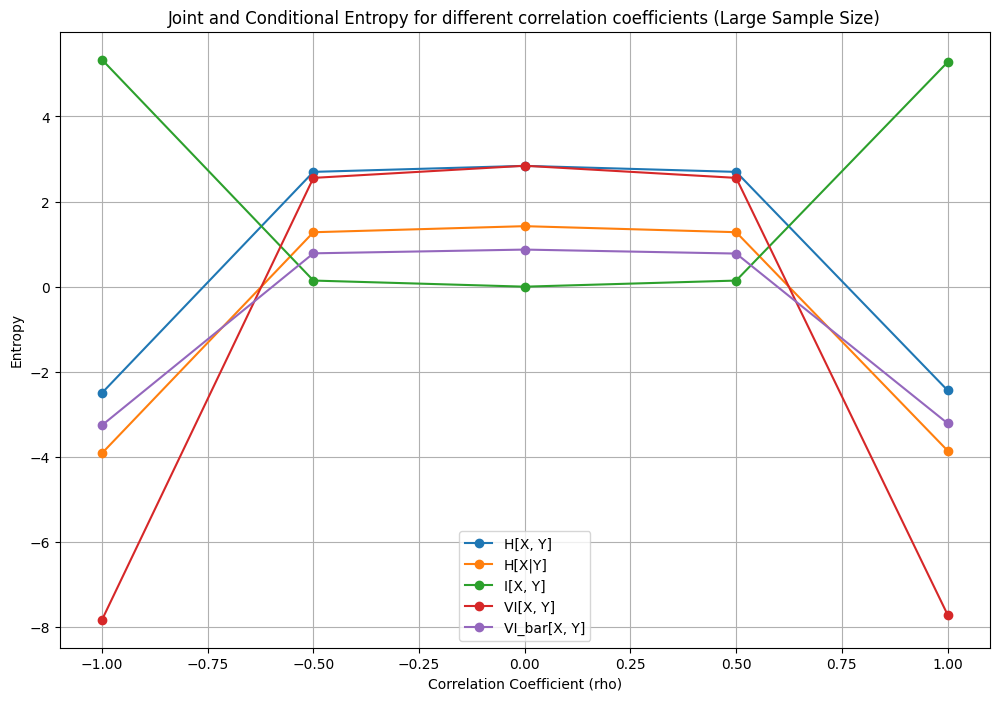

In [20]:
n_samples=1000000

rho_X_M=[]
for rho in rhos:
    cov=np.array([[1, rho], [rho, 1]])
    X_M=np.random.multivariate_normal(mu, cov, n_samples)
    rho_X_M.append(X_M)

H_X_M_list = []
H_Y_M_list = []
H_XY_M_list = []
H_X_given_Y_M_list = []
I_XY_M_list = []
VI_XY_M_list = []
VI_bar_XY_M_list = []
for i, rho in enumerate(rhos):  
    X_M = rho_X_M[i][:, 0]
    Y_M = rho_X_M[i][:, 1]
    
    H_X_M = get_entropy(X_M, bin_method='hacine-gharbi')
    H_Y_M = get_entropy(Y_M, bin_method='hacine-gharbi')
    H_XY_M = get_joint_entropy(X_M, Y_M, bin_method='hacine-gharbi')
    H_X_given_Y_M = get_conditional_entropy(X_M, Y_M, bin_method='hacine-gharbi')
    I_XY_M = get_mutual_information(X_M, Y_M, bin_method='hacine-gharbi')
    VI_XY_M = get_variation_of_information(X_M, Y_M, bin_method='hacine-gharbi')
    VI_bar_XY_M = get_variation_of_information(X_M, Y_M, normalized=True)

    H_X_M_list.append(H_X_M)
    H_Y_M_list.append(H_Y_M)
    H_XY_M_list.append(H_XY_M)
    H_X_given_Y_M_list.append(H_X_given_Y_M)
    I_XY_M_list.append(I_XY_M)
    VI_XY_M_list.append(VI_XY_M)
    VI_bar_XY_M_list.append(VI_bar_XY_M)


plt.figure(figsize=(12, 8))
plt.plot(rhos, H_X_M_list, marker='o', label='H[X]')
plt.plot(rhos, H_Y_M_list, marker='o', label='H[Y]')
plt.legend()
plt.title('Entropy of X and Y for different correlation coefficients (Large Sample Size)')
plt.xlabel('Correlation Coefficient (rho)')
plt.ylabel('Entropy')
plt.grid()
plt.show()  

plt.figure(figsize=(12, 8))
plt.plot(rhos, H_XY_M_list, marker='o', label='H[X, Y]')
plt.plot(rhos, H_X_given_Y_M_list, marker='o', label='H[X|Y]')
plt.plot(rhos, I_XY_M_list, marker='o', label='I[X, Y]')
plt.plot(rhos, VI_XY_M_list, marker='o', label='VI[X, Y]')
plt.plot(rhos, VI_bar_XY_M_list, marker='o', label='VI_bar[X, Y]')
plt.legend()
plt.title('Joint and Conditional Entropy for different correlation coefficients (Large Sample Size)')
plt.xlabel('Correlation Coefficient (rho)')
plt.ylabel('Entropy')
plt.grid()
plt.show()

4. What is the main advantage of variation of information over mutual informa
tion? Can you think of a use case in finance where mutual information is
more appropriate than variation of information?

가장 큰 장점은 variation of information은 upper bound가 존재한다는 것이다. 따라서 서로 길이가 다른 데이터들간의 정보량을 확인할 수 있다.
(월간 feature와 일간 feature 간의 정보량 비교)

5. Consider the two correlation-based distance metrics we discussed in Section
3.2. Can you think of a use case where those distance metrics would be
preferable to the normalized variation of information?

연산속도가 중요한 경우가 있을것이다. (correlation 연산은 벡터연산이 가능하기 때문에 매우 빠르다)
선형이나 순위 관계를 파악하고자는 목적일때

6. Code in Python a function to compute the KL divergence between two
discrete probability distributions.

In [28]:
from typing import Callable


def get_kl_divergence(p: Callable, q: Callable, data: np.ndarray) -> float:
    '''
    Estimates KL divergence D_KL(P || Q) = E_p[log(p(x)/q(x))] over given data
    '''
    kl = 0
    for x in data:
        px = p(x)
        qx = q(x)
        if px > 0 and qx > 0:
            kl += px * np.log(px / qx)
    return kl

7. Code in Python a function to compute the cross-entropy of two discrete
probability distributions.

In [29]:
def get_cross_entropy(p: Callable, q: Callable, data: np.ndarray) -> float:
    '''
    Estimates cross entropy H(P, Q) = -E_p[log q(x)]
    '''
    ce = 0
    for x in data:
        px = p(x)
        qx = q(x)
        if px > 0 and qx > 0:
            ce += -px * np.log(qx)
    return ce

8. Prove that $d_{\rho^{2}}[X, Y]=\sqrt{1-\rho(X, Y)^2}$ is also a proper metric

| 조건 번호                                  | 조건 (metric 정의)                   |
| -------------------------------------- | -------------------------------- |
| (1) 비음성 (non-negativity)               | $d(X, Y) \geq 0$                 |
| (2) 자기항등성 (identity of indiscernibles) | $d(X, Y) = 0 \iff X = Y$         |
| (3) 대칭성 (symmetry)                     | $d(X, Y) = d(Y, X)$              |
| (4) 삼각 부등식 (triangle inequality)       | $d(X, Z) \leq d(X, Y) + d(Y, Z)$ |
=> 삼각부등식의 경우 cosine-distance 계열이므로 $d[X, Y]=sin(\theta_{X, Y})$이고 이는 triangle inequality를 만족한다